## LAB 2 - TASK 3 submission. ML 2023-24
FILL UP THIS BOX WITH YOUR DETAILS

**NAME AND NIP**:

Eryka Liced Rimacuna Castillo 816778

Luis Salas Catalán            774274


## 3. Fine-tunning
Now we going to fine-tune a well known CNN architecture for image classification that has already been trained in ImageNet. We are going to fine-tune this for our own toy-dataset.

## Get data and tensorflow imports ready



In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16

import matplotlib.pyplot as plt

In [2]:
# GET YOUR IMAGES READY
from google.colab import drive
from PIL import Image
from tqdm import tqdm

drive.mount('/content/drive')

folder = '/content/drive/MyDrive/Informatica/Master/Machine_Learning/Practicas_ML/Practica4_816778_774272/'
image_folder = folder + 'images_5'
image_folder_classes = folder + 'subclasses_images_5'

Mounted at /content/drive


In [3]:
import os
import shutil
from tqdm import tqdm

def copy_images_to_directory(X, image_folder, output_folder):
    """
    Copies specified images from one directory to another, without creating subdirectories.

    Args:
        X (list): List of image filenames (with or without extensions).
        image_folder (str): Path to the source folder containing the images.
        output_folder (str): Path to the destination folder where images will be copied.
    """
    # Create the output folder if it does not exist
    os.makedirs(output_folder, exist_ok=True)

    for image_name in tqdm(X, desc="Copying images"):
        # Assume images are .jpg, adjust if needed
        source_path = os.path.join(image_folder, image_name + '.jpg')  # Add extension if not present
        destination_path = os.path.join(output_folder, image_name + '.jpg')

        # Try copying the image
        try:
            shutil.copy(source_path, destination_path)
        except FileNotFoundError:
            print(f"Warning: {source_path} not found.")
        except Exception as e:
            print(f"Error copying {source_path}: {e}")

    print(f"Copied {len(X)} images to {output_folder}")


def extract_x_y(file_read, selected_classes=None):
  X = []
  Y = []
  for line in file_read:
      if line.startswith("#"):
          continue  # Saltar comentarios
      parts = line.split()
      image_name = parts[0]
      class_id = int(parts[1])

      if selected_classes is None:
        X.append(image_name)
        Y.append(class_id)
      else:
        if class_id in selected_classes:
          X.append(image_name)
          Y.append(class_id)


  return X, Y

list_name = folder + 'list.txt'
with open(list_name, 'r') as f:
    list_data_name = f.readlines()
"""
selected_classes = [1, 2, 3, 4, 6]
X, Y = extract_x_y(list_data_name, selected_classes)
output_folder = folder + 'images_5'
copy_images_to_directory(X, image_folder, output_folder)
"""


"\nselected_classes = [1, 2, 3, 4, 6]\nX, Y = extract_x_y(list_data_name, selected_classes)\noutput_folder = folder + 'images_5'\ncopy_images_to_directory(X, image_folder, output_folder)\n"

In [4]:
# SOME HELPER FUNCTIONS TO VISUALIZE RESULTS
def vis_history(results_history):
    acc = results_history.history['accuracy']
    val_acc = results_history.history['val_accuracy']

    loss = results_history.history['loss']
    val_loss = results_history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [5]:
####### ***** TO-DO-LAB *****  #######
# make sure you config these params to fit what you want/need to LOAD YOUR DATA
# dimensions we will use with our images (they'll be resized if not this shape)
img_width, img_height = 224, 224 # TO MATCH THE SIZES OF THE BASE MODEL WE WANT TO USE, MOBILENET
# MODIFY THE PATH TO POINT TO YOUR DATA! locally here or in your mounted drive
data_dir = image_folder_classes # all in one folder and let the system do the split
nb_train_samples = 700 # UPDATE WITH YOUR NUMBERS!!
nb_validation_samples = 100 # UPDATE WITH YOUR NUMBERS!!
batch_size = 16 #16 4
num_classes = 5
####### ***** TO-DO-LAB *****  #######

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# for more optimized handling of the data
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 998 files belonging to 5 classes.
Using 799 files for training.
Found 998 files belonging to 5 classes.
Using 199 files for validation.


## Let's do the fine-tunning


Let's load the base model, and modify the final classification layers to adapt to our 5-class toy-dataset. In this example we are fine-tuning MobileNetV2.

There are plenty of base models you could use, this is a pretty good compromise quality vs speed. Many more models in: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [6]:
# weights = 'imagenet' is saying we want to upload the model ALREADY TRAINED in Imagenet
# THIS IS ESSENTIAL! otherwise we will just be training the architecture from scratch
IMG_SHAPE = (img_width, img_height) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


# We use the preprocessing method included with the model (for consistency with the pre-trained model we are using)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# apply data augmentation
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=IMG_SHAPE),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
# let's define our last layer depending on the number of classes we want to classify
prediction_layer = tf.keras.layers.Dense(5)

# Differently from previous example, in this cases it's more convenient
# to build our model using the Keras Model API (https://keras.io/api/models/)
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
# The base model contains batchnorm layers. It is ESSENTIAL TO SET IT AS inference mode
# SO when we unfreeze the base model for fine-tuning the batchnorm information is not distroyed
# So, we make sure that the base_model is running in inference mode here.
# more details on this in fine-tuning tutorial: https://www.tensorflow.org/guide/keras/transfer_learning
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


print("Let's leave the original model frozen for now ...")
# FREEZE the base model
base_model.trainable = False
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Let's leave the original model frozen for now ...
0 input_layer_2 True
1 sequential True
2 mobilenetv2_1.00_224 False
3 global_average_pooling2d True
4 dropout True
5 dense True


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.5333 - loss: 1.2126 - val_accuracy: 0.8995 - val_loss: 0.2769
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 970ms/step - accuracy: 0.8840 - loss: 0.3264 - val_accuracy: 0.9598 - val_loss: 0.1752
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 79s 920ms/step - accuracy: 0.9251 - loss: 0.2390 - val_accuracy: 0.9497 - val_loss: 0.1602
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 966ms/step - accuracy: 0.9134 - loss: 0.2369 - val_accuracy: 0.9447 - val_loss: 0.1654
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 919ms/step - accuracy: 0.9219 - loss: 0.1920 - val_accuracy: 0.9548 - val_loss: 0.1315
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 920ms/step - accuracy: 0.9457 - loss: 0.1709 - val_accuracy: 0.9648 - val_loss: 0.1140
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 926ms/step - accuracy: 0.9539 - loss: 0.1592 - val_accuracy: 0.9598 - val_loss: 0.1221
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9515 - loss: 0.1340 - val_accuracy:

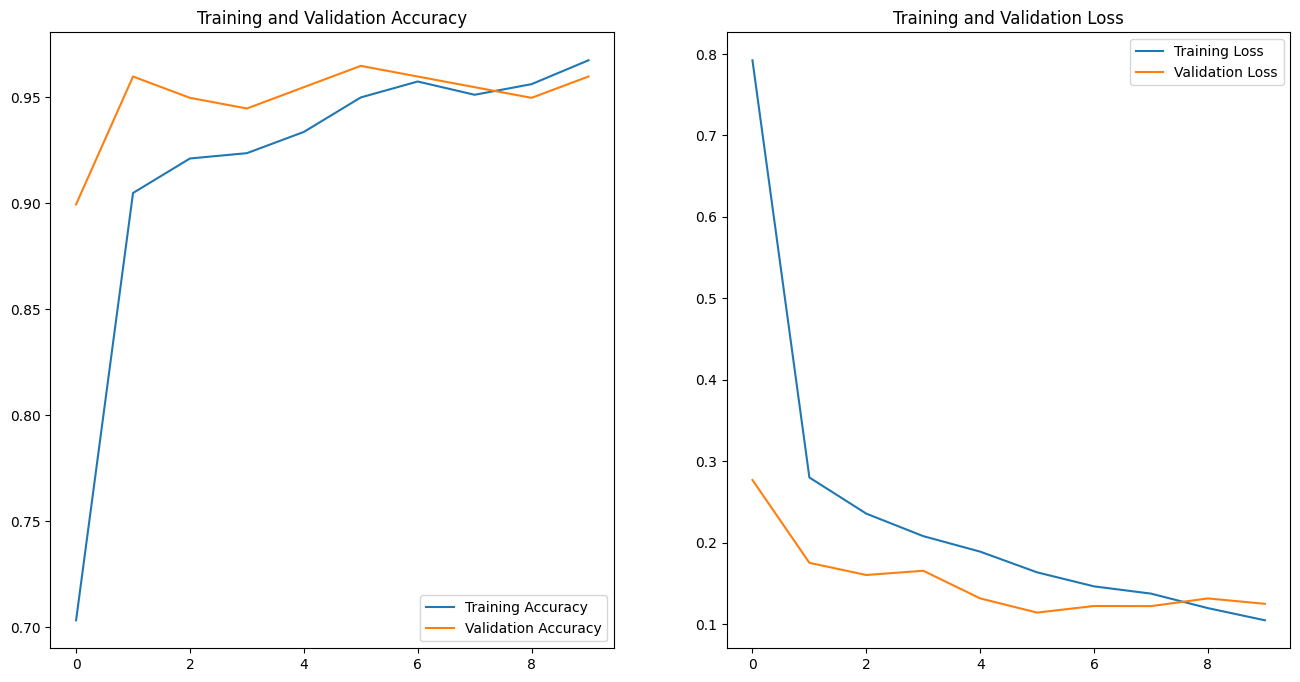

In [7]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 10 # UPDATE WITH YOUR NUMBERS!!
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

vis_history(history)

model.save('last_finetuned_model_V1.keras')

In [ ]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all base model layers
print("And now let's enable trainable flag to the BASE MODEL: ")
base_model.trainable = True
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

And now let's enable trainable flag to the BASE MODEL: 
0 input_layer_2 True
1 sequential True
2 mobilenetv2_1.00_224 True
3 global_average_pooling2d True
4 dropout True
5 dense True


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 2,230,277 (8.51 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 47s 91ms/step - accuracy: 0.7328 - loss: 0.7081 - val_accuracy: 0.9146 - val_loss: 0.2532
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.8749 - loss: 0.3692 - val_accuracy: 0.9296 - val_loss: 0.1940
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9343 - loss: 0.1885 - val_accuracy: 0.8995 - val_loss: 0.2591
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.9248 - loss: 0.1823 - val_accuracy: 0.9397 - val_loss: 0.2035
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9567 - loss: 0.1273 - val_accuracy: 0.9045 - val_loss: 0.3312
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9692 - loss: 0.0898 - val_accuracy: 0.9146 - val_loss: 0.3499
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.9642 - loss: 0.0857 - val_accuracy: 0.9045 - val_loss: 0.4635
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9644 - loss: 0.1170 - 

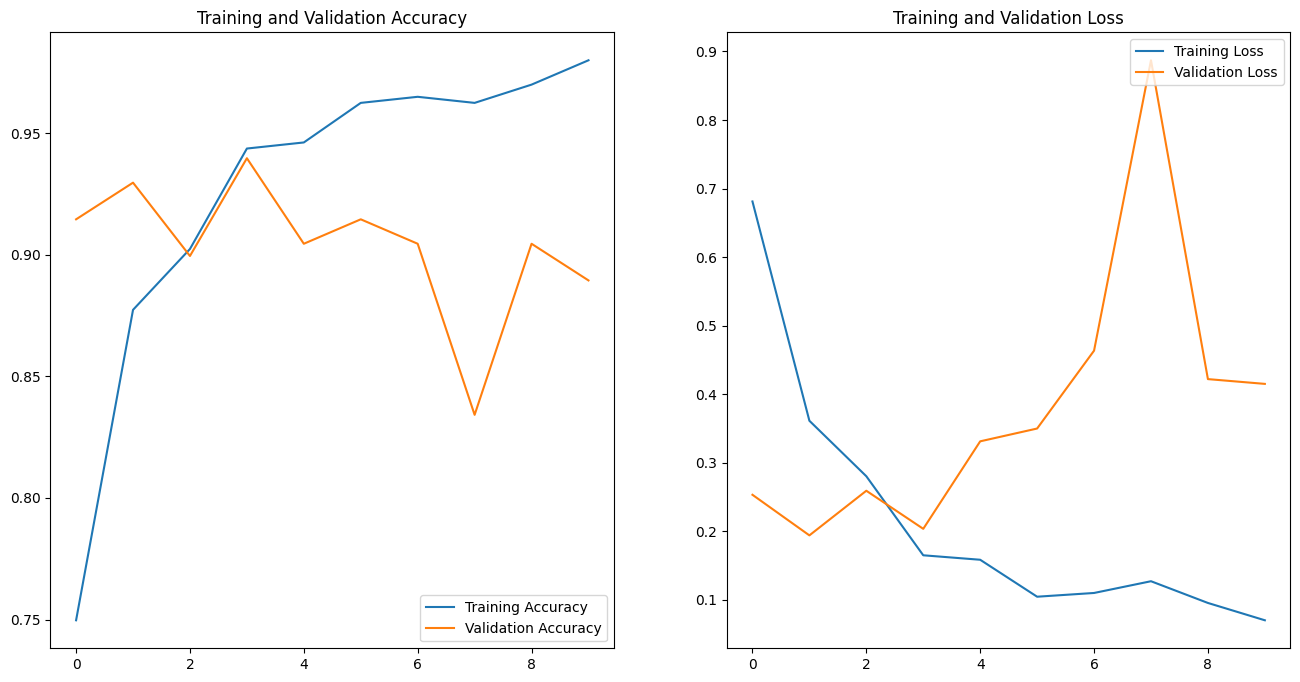

In [ ]:
epochs = 10 # UPDATE WITH YOUR NUMBERS!!

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
history2 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
vis_history(history2)

# Save the model
model.save('last_finetuned_model_V1.keras')

As a **final experiment, run a few (ONLY 2 or 3) variations to see HOW/IF your changes influence the results**.
- You can change learning rates (where do you think it makes sense to use smaller? larger?), optimizers, batch size, ...
- INSTEAD of just SAVING THE LAST MODEL. you can add this callback to save "check points" of your model (in this case is set to save only the best one found).
More info: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

You can add plenty of other "utilities" to run during your training process.
More info: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

### Model 1 (bach size 16)

In [ ]:
checkpoint_filepath = './tmp/checkpoint.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
#history2 = model.fit(
#  train_ds,
#  validation_data=val_ds,
#  epochs=epochs,
#  callbacks=[model_checkpoint_callback]
#)


In [ ]:
####### ***** TO-DO-LAB *****  #######
# make sure you config these params to fit what you want/need to LOAD YOUR DATA
# dimensions we will use with our images (they'll be resized if not this shape)
img_width, img_height = 224, 224 # TO MATCH THE SIZES OF THE BASE MODEL WE WANT TO USE, MOBILENET
# MODIFY THE PATH TO POINT TO YOUR DATA! locally here or in your mounted drive
data_dir = image_folder_classes # all in one folder and let the system do the split
nb_train_samples = 700 # UPDATE WITH YOUR NUMBERS!!
nb_validation_samples = 100 # UPDATE WITH YOUR NUMBERS!!
batch_size = 16 #16 4
num_classes = 5
####### ***** TO-DO-LAB *****  #######

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# for more optimized handling of the data
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# weights = 'imagenet' is saying we want to upload the model ALREADY TRAINED in Imagenet
# THIS IS ESSENTIAL! otherwise we will just be training the architecture from scratch
IMG_SHAPE = (img_width, img_height) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


# We use the preprocessing method included with the model (for consistency with the pre-trained model we are using)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# apply data augmentation
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=IMG_SHAPE),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
# let's define our last layer depending on the number of classes we want to classify
prediction_layer = tf.keras.layers.Dense(5)

# Differently from previous example, in this cases it's more convenient
# to build our model using the Keras Model API (https://keras.io/api/models/)
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
# The base model contains batchnorm layers. It is ESSENTIAL TO SET IT AS inference mode
# SO when we unfreeze the base model for fine-tuning the batchnorm information is not distroyed
# So, we make sure that the base_model is running in inference mode here.
# more details on this in fine-tuning tutorial: https://www.tensorflow.org/guide/keras/transfer_learning
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


print("Let's leave the original model frozen for now ...")
# FREEZE the base model
base_model.trainable = False
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)


Let's leave the original model frozen for now ...
0 input_layer_8 True
1 sequential_2 True
2 mobilenetv2_1.00_224 False
3 global_average_pooling2d_2 True
4 dropout_2 True
5 dense_2 True


In [ ]:
base_learning_rate = 1e-3
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.4867 - loss: 1.2590 - val_accuracy: 0.9397 - val_loss: 0.2484
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 68s 910ms/step - accuracy: 0.8664 - loss: 0.3648 - val_accuracy: 0.9648 - val_loss: 0.1583
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 933ms/step - accuracy: 0.9153 - loss: 0.2651 - val_accuracy: 0.9548 - val_loss: 0.1356
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 942ms/step - accuracy: 0.9315 - loss: 0.2174 - val_accuracy: 0.9548 - val_loss: 0.1283
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 934ms/step - accuracy: 0.9272 - loss: 0.2170 - val_accuracy: 0.9548 - val_loss: 0.1123
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9492 - loss: 0.1474 - val_accuracy: 0.9548 - val_loss: 0.1115
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 70s 888ms/step - accuracy: 0.9526 - loss: 0.1357 - val_accuracy: 0.9698 - val_loss: 0.1073
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 924ms/step - accuracy: 0.9613 - loss: 0.1284 - val_accuracy: 

### Model 2 (lr 0.1, 0.0001)

In [ ]:
def compile_and_execute(model, base_learning_rate, epochs, train_ds, val_ds, num_model):
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  model.summary()
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )
  vis_history(history)
  model.save(f'last_finetuned_model_V{num_model}.keras')
  return history, model



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 345s 598ms/step - accuracy: 0.6533 - loss: 14.9333 - val_accuracy: 0.9497 - val_loss: 2.0984
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 210ms/step - accuracy: 0.9097 - loss: 4.2995 - val_accuracy: 0.8844 - val_loss: 4.1363
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 85s 227ms/step - accuracy: 0.9034 - loss: 6.7519 - val_accuracy: 0.9447 - val_loss: 5.1081
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 223ms/step - accuracy: 0.9231 - loss: 5.1001 - val_accuracy: 0.9648 - val_loss: 1.9107
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 80s 214ms/step - accuracy: 0.9261 - loss: 3.8129 - val_accuracy: 0.9397 - val_loss: 4.0019
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 229ms/step - accuracy: 0.9278 - loss: 4.7315 - val_accuracy: 0.8945 - val_loss: 8.0904
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - accuracy: 0.9307 - loss: 4.4785 - val_accuracy: 0.9196 - val_loss: 4.3365
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 214ms/step - accuracy: 0.9431 - loss:

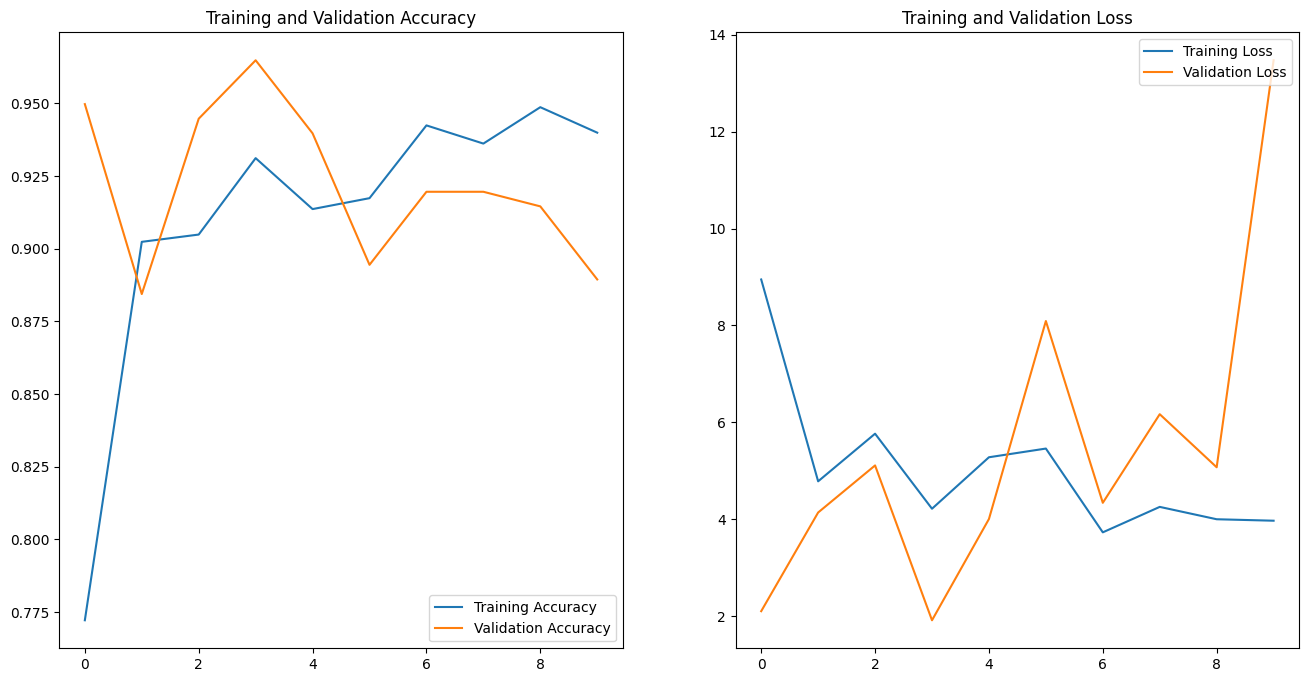

In [ ]:
epochs = 10
base_learning_rate = 0.1 # 0.0001 Bad results 0.88

# Freeze
history3, model3 = compile_and_execute(model, base_learning_rate, epochs, train_ds, val_ds, 3)

### Model 3 (enable trainable flag)

In [ ]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all base model layers
print("And now let's enable trainable flag to the BASE MODEL: ")
base_model.trainable = True
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

And now let's enable trainable flag to the BASE MODEL: 
0 input_layer_2 True
1 sequential True
2 mobilenetv2_1.00_224 True
3 global_average_pooling2d True
4 dropout True
5 dense True


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 2,230,277 (8.51 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 186s 748ms/step - accuracy: 0.1876 - loss: 8.1257 - val_accuracy: 0.2513 - val_loss: 5.0668
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 148s 739ms/step - accuracy: 0.2218 - loss: 6.6723 - val_accuracy: 0.2462 - val_loss: 4.2904
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 206s 757ms/step - accuracy: 0.1817 - loss: 6.2167 - val_accuracy: 0.2312 - val_loss: 3.5965
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 148s 740ms/step - accuracy: 0.1806 - loss: 5.6529 - val_accuracy: 0.2312 - val_loss: 3.0406
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 147s 735ms/step - accuracy: 0.1902 - loss: 4.9048 - val_accuracy: 0.2412 - val_loss: 2.5304
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 148s 742ms/step - accuracy: 0.1779 - loss: 4.6933 - val_accuracy: 0.2362 - val_loss: 2.1241
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 200s 731ms/step - accuracy: 0.1855 - loss: 4.1661 - val_accuracy: 0.2362 - val_loss: 1.8713
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 203s 733ms/step - accuracy: 0.1963 -

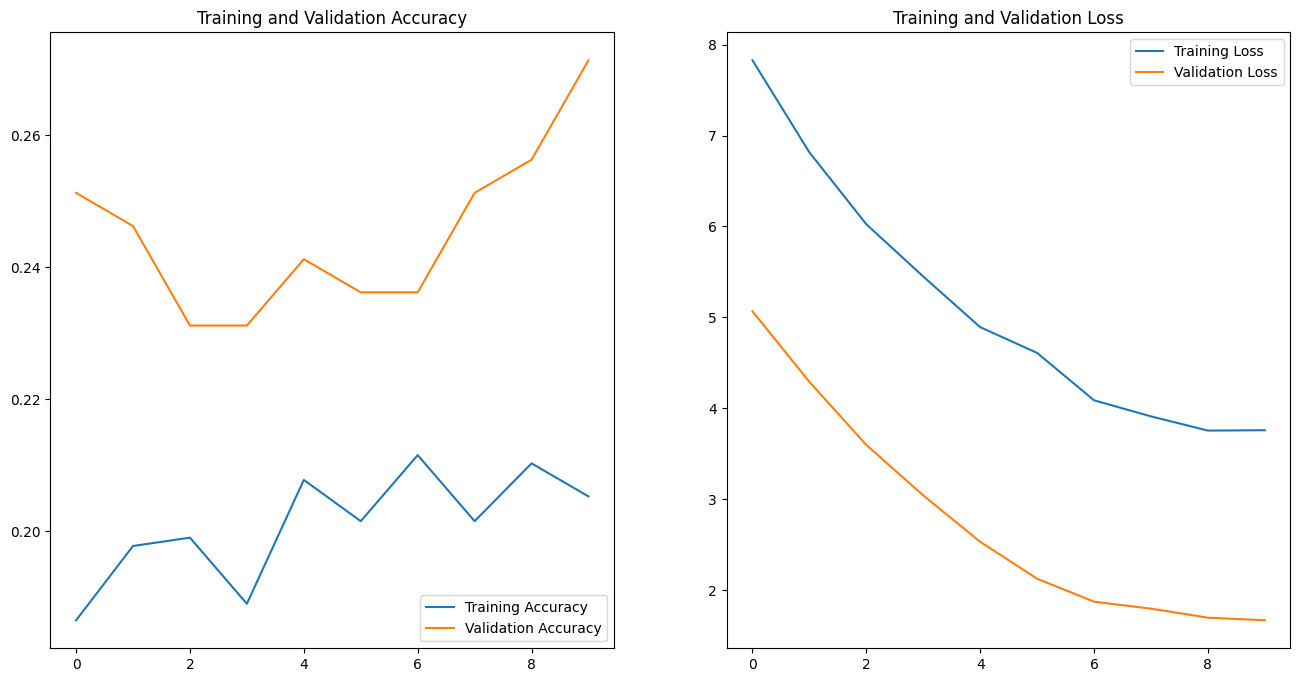

In [ ]:
epochs = 10
base_learning_rate = 0.0001

# No Freeze
history6, model6 = compile_and_execute(model, base_learning_rate, epochs, train_ds, val_ds, 6)

### **QUESTION 1**. Answer True/False and explain why you think so.

1. After reading the explanations in this notebook, we think when fine-tuning and existing model, we usually start with its layers frozen, but later we should un-freeze *ALL* layers always.

2.   It is essential to make sure when loading the base model, its parameter *weights* are initialized to the pre-trained weigths we want, usually imagenet.

ANSWER 1:

1. **False**: It's not necessary to unfreeze all layers. We can initially freeze the base model to train only the newly added layers and later unfreeze some or all layers, but is not mandatory

2. **True**: Because this ensures the model benefits from the knowledge is has already learned. Without doing that, the model would start with random initialization, losing the advantages of transfer learning

### **QUESTION 2**.
Discuss the results you have obtained with your toy-data after running the different steps of the fine tunning process and the variations you have incorporated.

* How does it compare to the previous tasks in this Lab 3? What are advantages/disadvantages you find within each option? (max 10 lines).





ANSWER 2:

Fine-tuning works best when starting with a frozen base model and training only the top layers before unfreezing for fine-tuning, because it leverages the knowledge already captured by the pre-trained weights.
Using moderate learning rates (1e-3) fensures that the training process is stable and the updates to the new layers do not interfere drastically with the established representations
Avoid using high learning rates like 0.1, because they can cause large updates to the weights, leading to loss of the pre-trained knowledge


**Simple 2NN (0.35%)**:  Fast training with fewer parameters, but lacks the capacity to learn complex features, as it's a basic fully connected network.

**SimpleCNN (0.59%)**: Uses convolutional layers and regularization, leading to better feature extraction and generalization, but still limited compared to pre-trained models due to training from scratch.

**CNN Finetuning**:  Leverages pre-trained weights for excellent generalization and feature extraction with minimal data but Higher computational cost